<a href="https://colab.research.google.com/github/JuliusR8ll/Complete-Feature-Selection/blob/master/HAM10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
import seaborn as sns

In [ ]:
!nvidia

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
skin_df = pd.read_csv('/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv')


In [4]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/HAM10000/', '*', '*.jpg'))}

In [5]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)

In [6]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

In [7]:
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


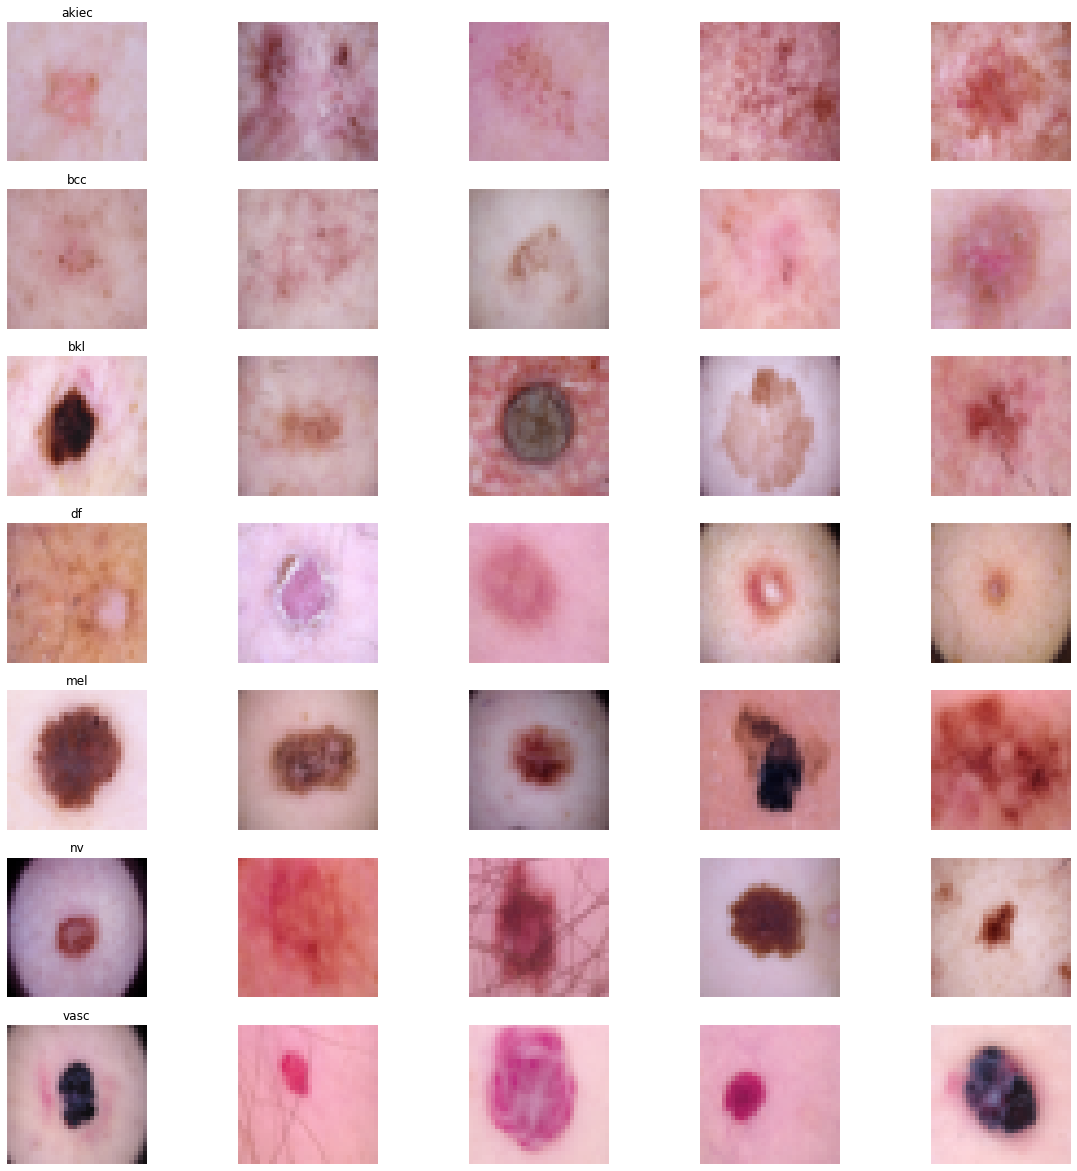

In [8]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [9]:
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [10]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [12]:
skin_df['label'] = le.transform(skin_df["dx"]) 

In [13]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [14]:
X = np.asarray(skin_df['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42,stratify=skin_df.label.values)

In [15]:
from tensorflow import keras
from tensorflow_hub import KerasLayer

In [49]:
model = Sequential()


In [40]:
model.add(KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
               trainable=True, arguments=dict(batch_norm_momentum=0.997)))

In [50]:
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(32, 32, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

In [51]:
model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))


In [52]:
model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

In [53]:
model.add(Dense(32))
model.add(Dense(7, activation='softmax'))

In [54]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [55]:
batch_size = 32 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/50
235/235 - 11s - loss: 1.0357 - acc: 0.6669 - val_loss: 0.9806 - val_acc: 0.6689 - 11s/epoch - 48ms/step
Epoch 2/50
235/235 - 2s - loss: 0.9392 - acc: 0.6719 - val_loss: 0.8833 - val_acc: 0.6713 - 2s/epoch - 8ms/step
Epoch 3/50
235/235 - 2s - loss: 0.9027 - acc: 0.6750 - val_loss: 0.9062 - val_acc: 0.6817 - 2s/epoch - 8ms/step
Epoch 4/50
235/235 - 2s - loss: 0.8713 - acc: 0.6865 - val_loss: 0.9004 - val_acc: 0.6857 - 2s/epoch - 8ms/step
Epoch 5/50
235/235 - 2s - loss: 0.8493 - acc: 0.6906 - val_loss: 0.8445 - val_acc: 0.7005 - 2s/epoch - 8ms/step
Epoch 6/50
235/235 - 2s - loss: 0.8346 - acc: 0.6947 - val_loss: 0.8252 - val_acc: 0.6997 - 2s/epoch - 7ms/step
Epoch 7/50
235/235 - 2s - loss: 0.7960 - acc: 0.7056 - val_loss: 0.8129 - val_acc: 0.7169 - 2s/epoch - 8ms/step
Epoch 8/50
235/235 - 2s - loss: 0.7847 - acc: 0.7076 - val_loss: 0.7659 - val_acc: 0.7288 - 2s/epoch - 8ms/step
Epoch 9/50
235/235 - 2s - loss: 0.7618 - acc: 0.7209 - val_loss: 0.7695 - val_acc: 0.7252 - 2s/epoch 

In [56]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

79/79 [==============================] - 0s 5ms/step - loss: 0.6524 - acc: 0.7676
Test accuracy: 0.7675718665122986


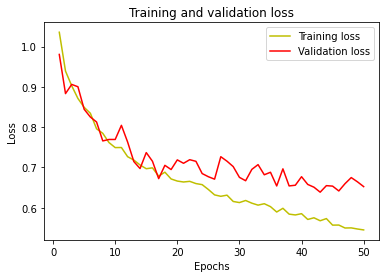

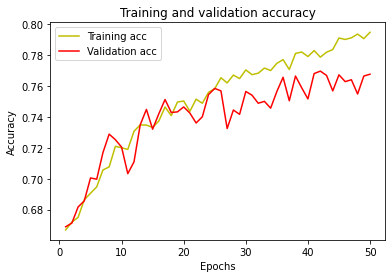

In [57]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [58]:
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

79/79 [==============================] - 0s 3ms/step


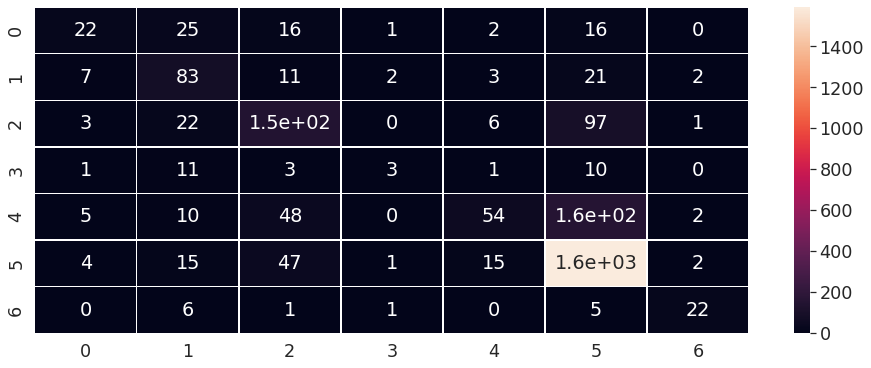

In [62]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(16,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

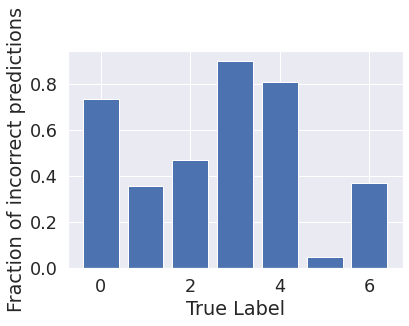

In [63]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [32]:
cnn.add(keras.layers.Dense(units=7, activation='softmax'))

In [33]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [38]:
cnn.fit(x_train, y_train,
        steps_per_epoch = 8000,
        epochs = 25,
        validation_data = (x_test, y_test),
        verbose = 2)


Epoch 1/25


ValueError: ignored